# Minimal Implementation for Dynamics of Specialization

In this example, we will implement a 2-agent modular architecture from https://arxiv.org/abs/2106.02626

We will examine 3 levels of structural modularity $Q$, by changing the amount of interconnection $p$ present between modules

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from functools import partial
import copy
from tqdm.notebook import tqdm
import matplotlib

In [2]:
%load_ext autoreload
%autoreload 0


## Data

### Generate

We generate double-MNIST data, suited for a 2-agent modular architecture

In [3]:
from dynspec.datasets import get_datasets
from dynspec.data_process import process_data

In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [5]:
n_agents = 2
n_classes_per_digit = 10
n_classes = n_classes_per_digit * n_agents
nb_steps = 5

data_config = {
    # ------ Change if needed------
    "batch_size": 256,
    "input_size": 28,
    "use_cuda": use_cuda,
    "data_type": "double_digits",
    "n_digits": n_agents,
    "n_classes": n_classes,
    "n_classes_per_digit": n_classes_per_digit,
    "nb_steps": nb_steps,
    # cov ratio : controls the probabilty of seeing D1 == D2, default = 1 (chance probability)
    "cov_ratio": 1,
    # noise ratio : controls the ammount of noise added to the input , default = 0.5
    "noise_ratio": .4,
    # random start : add stochasticity by having input start at random times from pure noise, default = False
    "random_start": False,
    # --------------------------
}

In [6]:
all_data = get_datasets("../data/", data_config)
datasets, loaders = all_data[data_config["data_type"]]
len(datasets[0])

60000

### Plot

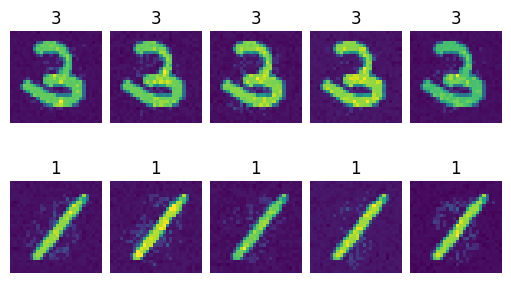

In [7]:
data, target = next(iter(loaders[0]))

temporal_data, _ = process_data(data, data_config)
temporal_data = torch.stack(
    temporal_data.split(temporal_data.shape[-1] // n_agents, -1), 1
)

fig, axs = plt.subplots(n_agents, temporal_data.shape[0], constrained_layout=True, figsize=(5, 3))
for t_data, t_axs in zip(temporal_data, axs.T):
    for d, ax, t in zip(t_data, t_axs, target[0].cpu().numpy()):
        ax.imshow(d[0].cpu().numpy().reshape(28, 28))
        ax.axis("off")
        ax.set_title(t)

## Init Models

In [8]:
import pandas as pd

In [9]:
from dynspec.models import Community
from dynspec.data_process import flatten_list
from dynspec.initialization import init_model
from torch.nn import RNN, GRU, RNNCell, GRUCell
from dynspec.utils import get_all_v_params, copy_and_change_config

In [10]:
task = ["parity-digits", "inv-parity-digits"]
# task = "1"
# task = 'sum'
# task = "bitxor"

agents_config = {
    "n_agents": 2,
    "hidden_size": None,  # will be changed later
    "n_layers": 1,
    "dropout": 0.0,
    "cell_type": str(RNN),
}

connections_config = {"sparsity": None}  # Will be changed later

n_outs = {
    "none": [10, 10],
    "parity-digits": 10,
    "inv-parity-digits": 10,
    "parity-digits-both": [10, 10],
    "parity-digits-sum": 2,
    "sum": 20,
    "bitxor": 16,
    "bitxor-last-1": 2,
    "1": 10,
    "0": 10,
    "inv": 10,
}

input_config = {"input_size": data_config["input_size"] ** 2, "common_input": False}
optim_config = {"lr": 1e-3, "weight_decay": 1e-5}

readout_config = {
    "common_readout": False,
}

decision = ["last", "max"]

training_config = {"n_epochs": 30, "task": task, "check_grad": True}

default_config = {
    "agents": agents_config,
    "connections": connections_config,
    "input": input_config,
    "readout": readout_config,
    "data": data_config,
    "decision": decision,
    "training": training_config,
    "optim": optim_config,
}

In [11]:
# We look at networks of 3 sizes and 3 sparsity levels
n_hiddens = [10, 25, 50]
# Negative values for the sparsity field directly specify number of connection irrelevent of the hidden size
sparsities = [-1, .1, 0.5]
varying_params = {"hidden_size": n_hiddens, "sparsity": sparsities}
# We get all the combinations of the parameters
all_varying_params = get_all_v_params(varying_params)
len(all_varying_params)

9

In [20]:
try : 
    general_training_results = pd.read_pickle("../results/example/general_training_results")
except FileNotFoundError:
    general_training_results = {}
    
general_training_results

,hidden_size,sparsity,config,model,optimizer,train_results
0,10,-1.0,"{'agents': {'n_agents': 2, 'hidden_size': 10, ...","{'input_mask': [[tensor(1.), tensor(1.), tenso...",AdamW (\nParameter Group 0\n amsgrad: False...,"{'train_losses': [2.3754842281341553, 2.323023..."
1,10,0.1,"{'agents': {'n_agents': 2, 'hidden_size': 10, ...","{'input_mask': [[tensor(1.), tensor(1.), tenso...",AdamW (\nParameter Group 0\n amsgrad: False...,"{'train_losses': [2.336785316467285, 2.3606708..."
2,10,0.5,"{'agents': {'n_agents': 2, 'hidden_size': 10, ...","{'input_mask': [[tensor(1.), tensor(1.), tenso...",AdamW (\nParameter Group 0\n amsgrad: False...,"{'train_losses': [2.3481974601745605, 2.339591..."
3,25,-1.0,"{'agents': {'n_agents': 2, 'hidden_size': 25, ...","{'input_mask': [[tensor(1.), tensor(1.), tenso...",AdamW (\nParameter Group 0\n amsgrad: False...,"{'train_losses': [2.378772735595703, 2.3751683..."
4,25,0.1,"{'agents': {'n_agents': 2, 'hidden_size': 25, ...","{'input_mask': [[tensor(1.), tensor(1.), tenso...",AdamW (\nParameter Group 0\n amsgrad: False...,None
5,25,0.5,"{'agents': {'n_agents': 2, 'hidden_size': 25, ...","{'input_mask': [[tensor(1.), tensor(1.), tenso...",AdamW (\nParameter Group 0\n amsgrad: False...,None
6,50,-1.0,"{'agents': {'n_agents': 2, 'hidden_size': 50, ...","{'input_mask': [[tensor(1.), tensor(1.), tenso...",AdamW (\nParameter Group 0\n amsgrad: False...,None
7,50,0.1,"{'agents': {'n_agents': 2, 'hidden_size': 50, ...","{'input_mask': [[tensor(1.), tensor(1.), tenso...",AdamW (\nParameter Group 0\n amsgrad: False...,None
8,50,0.5,"{'agents': {'n_agents': 2, 'hidden_size': 50, ...","{'input_mask': [[tensor(1.), tensor(1.), tenso...",AdamW (\nParameter Group 0\n amsgrad: False...,None


In [21]:
general_training_results['state_dicts'] = general_training_results['model']

In [32]:
if general_training_results is {} : 
        
    n_tests = 1
    for v_p in all_varying_params:
        for _ in range(n_tests):
            for n, v in v_p.items():
                general_training_results.setdefault(n, []).append(v)

            config = copy_and_change_config(default_config, v_p)
            general_training_results.setdefault("config", []).append(config)
    for config in general_training_results["config"]:
        model, optimizer = init_model(config, device)

        general_training_results.setdefault("model", []).append(model)
        general_training_results.setdefault("optimizer", []).append(optimizer)
    general_training_results = pd.DataFrame.from_dict(general_training_results)

else : 
    models = []
    for config, state_dict in general_training_results[["config", "state_dicts"]].values:
        model, optimizer = init_model(config, device)
        model.load_state_dict(state_dict)
        models.append(model)
    general_training_results["model"] = models

In [34]:
general_training_results

,hidden_size,sparsity,config,model,optimizer,train_results,state_dicts
0,10,-1.0,"{'agents': {'n_agents': 2, 'hidden_size': 10, ...",Community(\n (core): ParametrizedRNN(\n 15...,AdamW (\nParameter Group 0\n amsgrad: False...,"{'train_losses': [2.3754842281341553, 2.323023...","{'input_mask': [[tensor(1.), tensor(1.), tenso..."
1,10,0.1,"{'agents': {'n_agents': 2, 'hidden_size': 10, ...",Community(\n (core): ParametrizedRNN(\n 15...,AdamW (\nParameter Group 0\n amsgrad: False...,"{'train_losses': [2.336785316467285, 2.3606708...","{'input_mask': [[tensor(1.), tensor(1.), tenso..."
2,10,0.5,"{'agents': {'n_agents': 2, 'hidden_size': 10, ...",Community(\n (core): ParametrizedRNN(\n 15...,AdamW (\nParameter Group 0\n amsgrad: False...,"{'train_losses': [2.3481974601745605, 2.339591...","{'input_mask': [[tensor(1.), tensor(1.), tenso..."
3,25,-1.0,"{'agents': {'n_agents': 2, 'hidden_size': 25, ...",Community(\n (core): ParametrizedRNN(\n 15...,AdamW (\nParameter Group 0\n amsgrad: False...,"{'train_losses': [2.378772735595703, 2.3751683...","{'input_mask': [[tensor(1.), tensor(1.), tenso..."
4,25,0.1,"{'agents': {'n_agents': 2, 'hidden_size': 25, ...",Community(\n (core): ParametrizedRNN(\n 15...,AdamW (\nParameter Group 0\n amsgrad: False...,None,"{'input_mask': [[tensor(1.), tensor(1.), tenso..."
5,25,0.5,"{'agents': {'n_agents': 2, 'hidden_size': 25, ...",Community(\n (core): ParametrizedRNN(\n 15...,AdamW (\nParameter Group 0\n amsgrad: False...,None,"{'input_mask': [[tensor(1.), tensor(1.), tenso..."
6,50,-1.0,"{'agents': {'n_agents': 2, 'hidden_size': 50, ...",Community(\n (core): ParametrizedRNN(\n 15...,AdamW (\nParameter Group 0\n amsgrad: False...,None,"{'input_mask': [[tensor(1.), tensor(1.), tenso..."
7,50,0.1,"{'agents': {'n_agents': 2, 'hidden_size': 50, ...",Community(\n (core): ParametrizedRNN(\n 15...,AdamW (\nParameter Group 0\n amsgrad: False...,None,"{'input_mask': [[tensor(1.), tensor(1.), tenso..."
8,50,0.5,"{'agents': {'n_agents': 2, 'hidden_size': 50, ...",Community(\n (core): ParametrizedRNN(\n 15...,AdamW (\nParameter Group 0\n amsgrad: False...,None,"{'input_mask': [[tensor(1.), tensor(1.), tenso..."


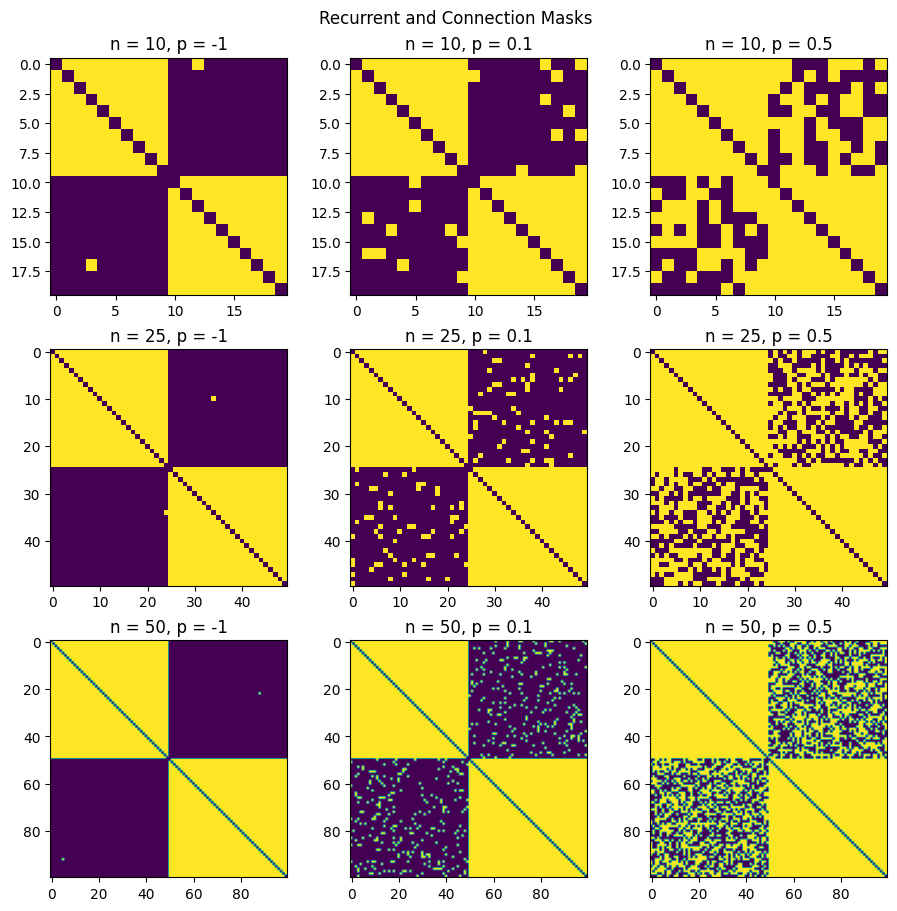

In [41]:
n1, n2 = int(np.sqrt(len(general_training_results["config"]))), int(
    np.ceil(np.sqrt(len(general_training_results["config"])))
)
if n1 * n2 < len(general_training_results):
    n2 += 1

plot_input = False
fig = plt.figure(
    figsize=(n2 * 3, n1 * 3 * (1 + plot_input * 0.3)), constrained_layout=True
)

subfigs = fig.subfigures(1 + plot_input, height_ratios=[1, 0.3][: (1 + plot_input)])
if not plot_input:
    subfigs = np.array([subfigs])

subfigs[0].suptitle("Recurrent and Connection Masks")
axs = subfigs[0].subplots(n1, n2)
if len(general_training_results) == 1:
    axs = np.array([axs]).T

for ax, model in zip(axs.flatten(), general_training_results["model"]):
    ax.imshow(
        (
            model.masks["comms_mask"][
                : model.n_agents * model.agents_config["hidden_size"]
            ]
            + model.masks["rec_mask"][
                : model.n_agents * model.agents_config["hidden_size"]
            ]
        )
        .cpu()
        .numpy(),
        vmin=0,
        vmax=1,
    )
    ax.set_title(
        f'n = {model.agents_config["hidden_size"]}, p = {model.connections_config["sparsity"]}'
    )

if plot_input:
    subfigs[1].suptitle("Input Masks")
    axs = subfigs[1].subplots(n1, n2)
    if len(general_training_results) == 1:
        axs = np.array([axs]).T
    for ax, model in zip(axs, general_training_results["model"]):
        ax.imshow(
            (model.masks["input_mask"])
            .cpu()
            .numpy()[: model.n_agents * model.agents_config["hidden_size"], :],
            aspect="auto",
            vmin=0,
            vmax=1,
        )

# [ax.imshow((model.masks['output_mask']).cpu().numpy()) for model, ax in zip(models, axs[2])];

core.parametrizations.weight_ih_l0.original tensor(0.0013)
core.parametrizations.weight_hh_l0.original tensor(0.0015)
readout.parametrizations.weight.original tensor(0.0157)


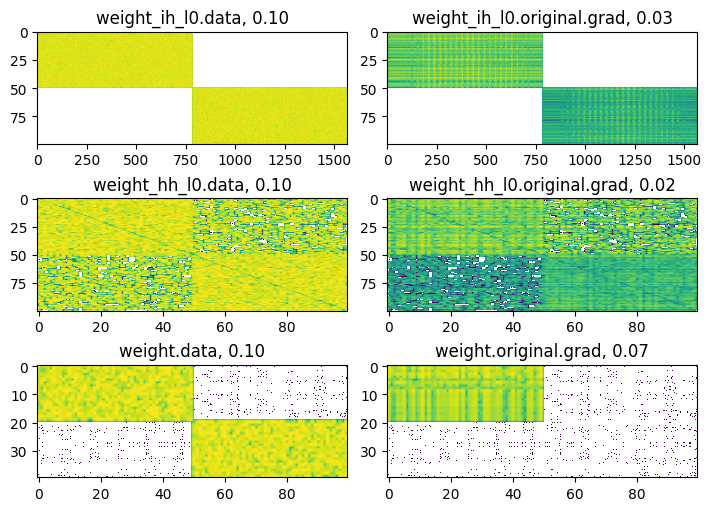

In [ ]:
from operator import attrgetter

decider = 0
nullify_own_input = False

data, target = next(iter(loaders[0]))
temporal_data, _ = process_data(data, data_config)

if nullify_own_input:
    temporal_data = list(temporal_data.split(temporal_data.shape[-1] // 2, -1))
    temporal_data[decider] *= 0
    temporal_data = torch.cat(temporal_data, -1)

out, states = model(temporal_data.to(device))
optimizer.zero_grad()
loss = nn.CrossEntropyLoss()(out[-1][decider], target[:, 1 - decider].to(device))
loss.backward()


def plot_weights_and_grad(model):
    fig, axs = plt.subplots(3, 2, constrained_layout=True, figsize=(7, 5))
    for (layer, w), ax in zip(
        product(
            [
                "core.weight_ih_l0",
                "core.weight_hh_l0",
                "readout.weight",
            ],
            ["data", "original.grad"],
        ),
        axs.flatten(),
    ):
        if w == "original.grad":
            layer = layer.replace(".", ".parametrizations.")

        tensor = attrgetter(f"{layer}.{w}")(model)
        # if 'ih' in layer:
            # tensor = tensor.mean(0).view(2*28, 28)
        if hasattr(tensor, "cpu"):
            tensor = tensor.abs().cpu().data
            ax.imshow(
                tensor,
                aspect="auto",
                cmap="viridis",
                norm=matplotlib.colors.LogNorm(
                    vmin=tensor.abs().min(),
                    vmax=tensor.abs().max(),
                ),
            )
        ax.set_title(f"{layer.split('.')[-1]}.{w}, {tensor.max().item() :.2f}")


plot_weights_and_grad(model)

for n, p in model.named_parameters():
    if p.requires_grad:
        print(n, p.grad[p.grad != 0].abs().float().mean())

In [103]:
decider = 0
nullify_own_input = False
clip = 1e-1

for ep in range(10) : 
    pbar = tqdm(loaders[0], leave=False)
    for i, (data, target) in enumerate(pbar):
        data, target = process_data(data, data_config)[0].to(device), target.to(device)
        # data[..., :data.shape[-1]//2] = 0

        if nullify_own_input:
            data = list(data.split(data.shape[-1]//2, -1))
            data[decider] *= 0
            data = torch.cat(data, -1)

        out, states = model(data)
        optimizer.zero_grad()
        target = target[:, 1-decider]
        
        loss = nn.CrossEntropyLoss()(out[-1][decider], target)
        acc = out[-1][decider].argmax(-1).eq(target).float().mean()
        loss.backward()
        optimizer.step()
        pbar.set_description(f"Loss : {loss.item():.3f}, Acc : {acc.item():.3f}")

  0%|          | 0/234 [00:00<?, ?it/s]

  0%|          | 0/234 [00:00<?, ?it/s]

  0%|          | 0/234 [00:00<?, ?it/s]

  0%|          | 0/234 [00:00<?, ?it/s]

  0%|          | 0/234 [00:00<?, ?it/s]

  0%|          | 0/234 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Training

In [33]:
from dynspec.training import train_community, get_acc, get_loss
from dynspec.decision import get_decision
from dynspec.tasks import get_task_target

In [42]:
train_results = []
for model, optimizer, config in general_training_results[
    ["model", "optimizer", "config"]
].values:
    train_results.append(
        train_community(
            model,
            optimizer,
            config,
            loaders,
            stop_acc=0.95,
            device=device,
            show_all_acc=True,
            n_epochs=50,
        )
    )

Train Epoch::   0%|          | 0/51 [00:00<?, ?it/s]

/home/gbena/anaconda3/envs/dynspec/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gbena/anaconda3/envs/dynspec/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Train Epoch::   0%|          | 0/51 [00:00<?, ?it/s]

Train Epoch::   0%|          | 0/51 [00:00<?, ?it/s]

Train Epoch::   0%|          | 0/51 [00:00<?, ?it/s]

Train Epoch::   0%|          | 0/51 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [44]:
train_results += [None for _ in range(len(general_training_results) - len(train_results))]

In [45]:
general_training_results["train_results"] = train_results

In [59]:
general_training_results.to_pickle("../results/example/general_training_results")
# torch.save(train_results, '../results/train_results')

In [57]:
general_training_results

KeyboardInterrupt: 

In [55]:
general_training_results['model'] = general_training_results['model'].apply(lambda x : x.state_dict())

### Results

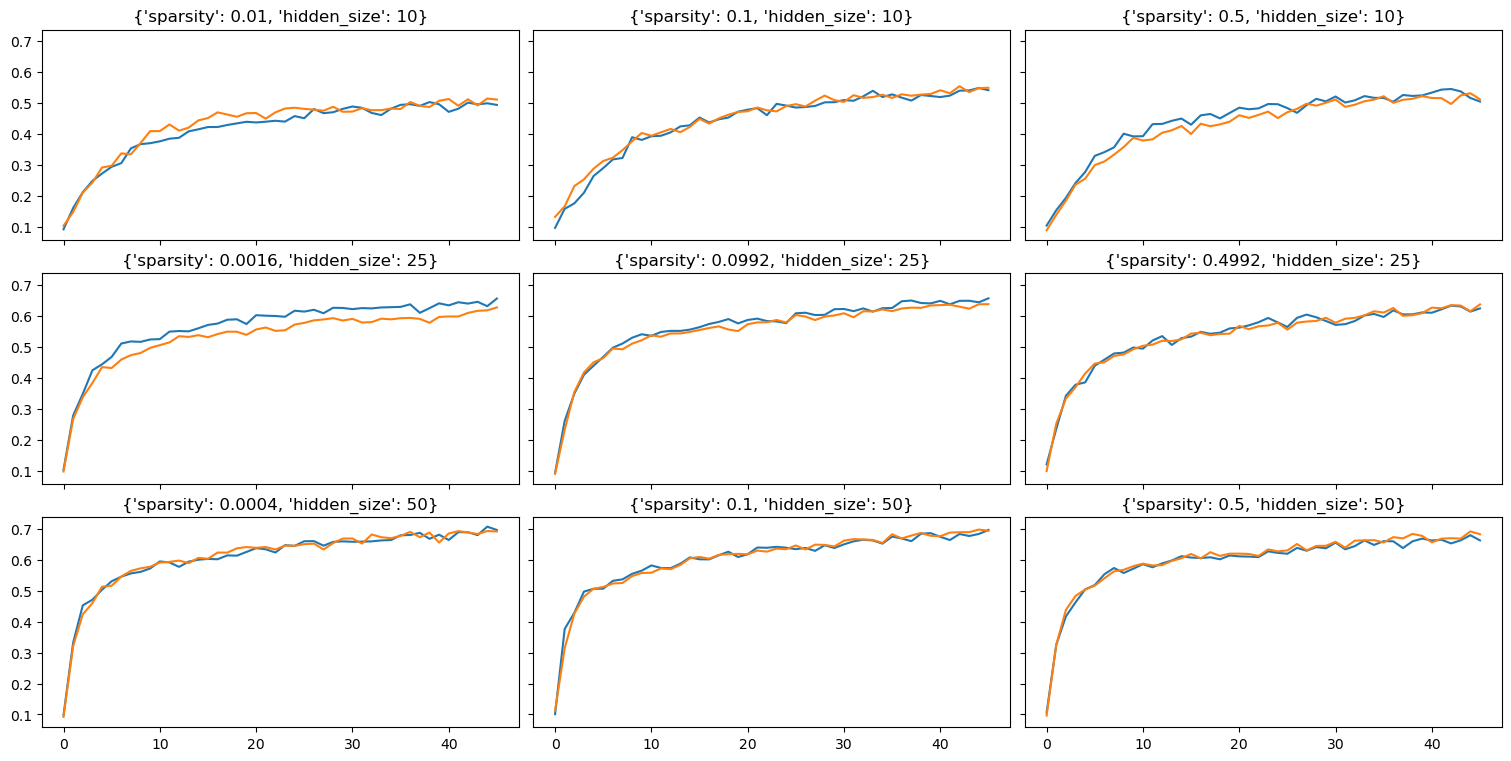

In [ ]:
n1, n2 = int(np.sqrt(len(all_configs))), int(np.ceil(np.sqrt(len(all_configs))))
if n1 * n2 < len(all_configs):
    n2 += 1

fig, axs = plt.subplots(
    n1,
    n2,
    figsize=(5 * n2, n1 * 2.5),
    constrained_layout=True,
    sharey=True,
    sharex=True,
)
if n1 == n2 == 1:
    axs = np.array([axs])

for vp, t, ax in zip(all_varying_params, train_results, axs.flatten()):
    ax.plot(t["test_accs"].reshape(t["test_accs"].shape[0], -1))
    ax.set_title(vp)

In [ ]:
raise StopIteration

### Analysis

In [ ]:
model = models[0]
data, target = next(iter(loaders[1]))
data, _ = process_data(data, data_config)
data.shape
out, states = model(data.to(device))
t_target = get_task_target(target, task, data_config["n_classes_per_digit"])[1]

In [ ]:
comms_sent = states[
    ...,
    (model.comms_mask.split(100, 0)[0] * (1 - model.state_mask.split(100, 0)[0]))
    .to(bool)
    .any(1),
][-1]
comms_received = states[
    ...,
    (model.comms_mask.split(100, 0)[0] * (1 - model.state_mask.split(100, 0)[0]))
    .to(bool)
    .any(0),
][-1]

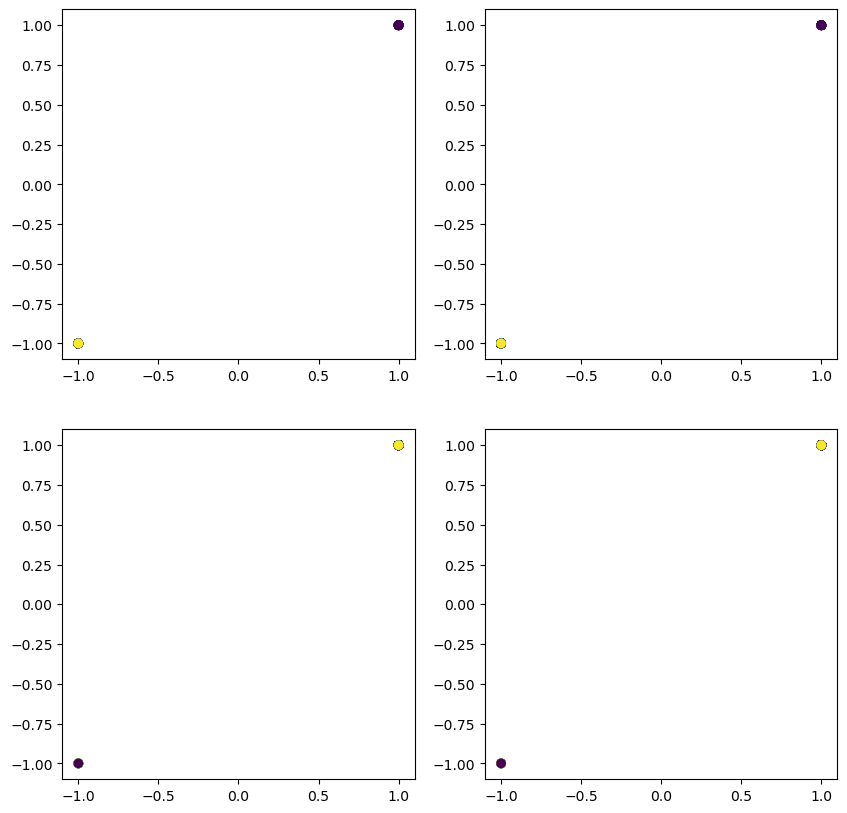

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
try:
    axs[0]
except TypeError:
    axs = np.array([axs])
for comms, axs_c in zip([comms_sent, comms_received], axs):
    try:
        axs_c[0]
    except TypeError:
        axs_c = np.array([axs_c])
    for (i, j), ax in zip(product(range(2), repeat=2), axs_c.flatten()):
        try:
            ax.scatter(
                comms[:, 2 * i].cpu().data.numpy(),
                comms[:, 2 * i].cpu().data.numpy(),
                c=t_target,
            )
        except IndexError:
            ax.scatter(
                range(len(comms[:, i])), comms[:, i].cpu().data.numpy(), c=t_target
            )

## Metrics

In [ ]:
from dynspec.plotting import set_style, filter_data
import pandas as pd
import seaborn as sns
from matplotlib.colors import LogNorm

### Retraining

In [ ]:
from dynspec.metrics import compute_retraining_metric

In [ ]:
if False:
    try:
        pool = mp.Pool(processes=len(models))
        retrain_results = pool.starmap(
            compute_retraining_metric,
            zip(
                models,
                all_configs,
                [copy.deepcopy(loaders) for _ in all_configs],
                [device for _ in all_configs],
                [i == len(all_configs) - 1 for i in range(len(all_configs))],
            ),
        )
    finally:
        pool.close()

else:
    retrain_results = [
        compute_retraining_metric(model, config, loaders, device, use_tqdm=True)
        for model, config in zip(models, all_configs)
    ]

Train Epoch::   0%|          | 0/6 [00:00<?, ?it/s]

/home/gb21/.conda/envs/dynspec/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gb21/.conda/envs/dynspec/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Train Epoch::   0%|          | 0/6 [00:00<?, ?it/s]

Train Epoch::   0%|          | 0/6 [00:00<?, ?it/s]

Train Epoch::   0%|          | 0/6 [00:00<?, ?it/s]

Train Epoch::   0%|          | 0/6 [00:00<?, ?it/s]

Train Epoch::   0%|          | 0/6 [00:00<?, ?it/s]

Train Epoch::   0%|          | 0/6 [00:00<?, ?it/s]

Train Epoch::   0%|          | 0/6 [00:00<?, ?it/s]

Train Epoch::   0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
retraining_metrics, retraining_models, retraining_configs = [
    [r[i] for r in retrain_results] for i in range(3)
]

In [ ]:
# torch.save(retrain_results, '../results/retrain_results')

In [ ]:
metric_norm = lambda m: np.clip(m - 0.1 / (1 - 0.1), 0, 1)
diff_metric = lambda metric: (metric[0] - metric[1]) / ((metric[0]) + (metric[1]))
global_diff_metric = (
    lambda metric: np.abs(diff_metric(metric[0]) - diff_metric(metric[1])) / 2
)

det = lambda M: np.abs(np.linalg.det(M))
diff_metric = lambda col: (col[0] - col[1]) / col.sum()
normed_det = lambda M: det(M) / M.sum(0).prod()

In [ ]:
retrain_accs = [metric_norm(r["test_accs"][-1]) for r in retraining_metrics]
retrain_all_accs = [metric_norm(r["all_accs"][-1]) for r in retraining_metrics]

In [ ]:
retrain_global_data = {k: [] for k in ["metric", "step"]}
for r_accs, vp in zip(retrain_accs, all_varying_params):
    retrain_global_data["metric"].extend(global_diff_metric(r) for r in r_accs)
    for k, v in vp.items():
        retrain_global_data.setdefault(k, [])
        retrain_global_data[k].extend([v] * len(r_accs))

    retrain_global_data["step"].extend(range(len(r_accs)))

retrain_global_data = pd.DataFrame(retrain_global_data)

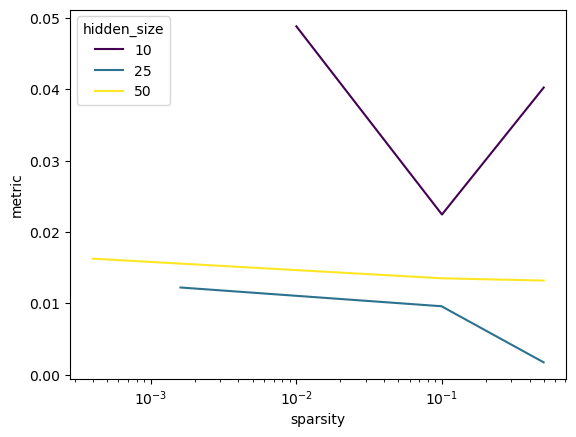

In [ ]:
sns.lineplot(
    data=filter_data(retrain_global_data, {"step": nb_steps - 1})[0],
    x="sparsity",
    y="metric",
    palette="viridis",
    hue="hidden_size",
)
plt.xscale("log")
# plt.yscale("log")

In [ ]:
retrain_ag_data = {k: [] for k in ["metric", "n_conns", "step", "ag"]}

for r_accs, conns in zip(
    retrain_accs, np.array([n_conns for _ in range(n_tests)]).flatten()
):
    for step, s_accs in enumerate(r_accs):
        for ag, ag_accs in enumerate(s_accs[:2]):
            retrain_ag_data["metric"].append(diff_metric(ag_accs))
            retrain_ag_data["n_conns"].append(conns)
            retrain_ag_data["step"].append(step)
            retrain_ag_data["ag"].append(ag)

retrain_ag_data = pd.DataFrame.from_dict(retrain_ag_data)

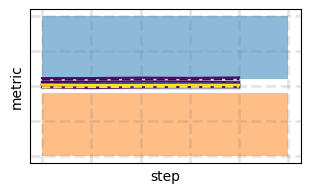

In [ ]:
fig, ax = plt.subplots(figsize=(3.5, 2))

l = sns.lineplot(
    data=retrain_ag_data,
    x="step",
    y="metric",
    hue="n_conns",
    style="ag",
    palette="viridis",
    ax=ax,
)

c1 = ax.fill_betweenx([0.1, 1], 0, nb_steps, alpha=0.5, label="M0")
c2 = ax.fill_betweenx([-0.1, -1], 0, nb_steps, alpha=0.5, label="M1")
ax.legend().remove()

ax.grid(True, alpha=0.2, linestyle="dashed", linewidth=2, color="grey")
ax.set_yticklabels([])
ax.set_xticklabels([])

for tick in ax.xaxis.get_major_ticks():
    tick.tick1line.set_visible(False)
    tick.tick2line.set_visible(False)
    tick.label1.set_visible(False)
    tick.label2.set_visible(False)
for tick in ax.yaxis.get_major_ticks():
    tick.tick1line.set_visible(False)
    tick.tick2line.set_visible(False)
    tick.label1.set_visible(False)
    tick.label2.set_visible(False)

### Random Timings

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
all_outputs = []
all_start_times = []
all_targets = []

random_config = config.copy()
random_config["data"]["random_start"] = True


def reccursive_stack(input):
    try:
        return torch.stack(input)
    except TypeError:
        return torch.stack([reccursive_stack(i) for i in input])


for n, n_s in enumerate(tqdm(n_conns)):
    all_outputs.append([])
    all_start_times.append([])
    all_targets.append([])

    for net, config in zip(
        retraining_models[n :: len(n_conns)], all_configs[n :: len(n_conns)]
    ):
        all_outputs[-1].append([])
        all_start_times[-1].append([])
        all_targets[-1].append([])

        for data, target in loaders[1]:
            data, start_times = process_data(data, random_config["data"])
            data, target = data.to(device), target.to(device)
            outputs, _ = net(data)
            outputs = reccursive_stack(outputs).transpose(0, 2).squeeze()
            all_outputs[-1][-1].append(outputs)  # steps x agents x target
            all_start_times[-1][-1].append(start_times)
            all_targets[-1][-1].append(target)

        all_outputs[-1][-1] = torch.cat(all_outputs[-1][-1], -2)
        all_start_times[-1][-1] = torch.cat(all_start_times[-1][-1], -2)
        all_targets[-1][-1] = torch.cat(all_targets[-1][-1], -2)

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
all_outputs, all_start_times, all_targets = [
    {n_s: reccursive_stack(r).squeeze() for n_s, r in zip(n_conns, all_r)}
    for all_r in [all_outputs, all_start_times, all_targets]
]

In [ ]:
if n_tests == 1:
    all_outputs, all_targets, all_start_times = [
        {n: t.unsqueeze(0) for n, t in d.items()}
        for d in [all_outputs, all_targets, all_start_times]
    ]

In [ ]:
all_accs = {
    n_s: np.stack(
        [
            get_acc(
                o,
                [
                    [[t for t in target.T] for _ in range(n_agents + 1)]
                    for _ in range(nb_steps)
                ],
            )[1]
            for o, target in zip(all_outs, all_ts)
        ]
    )
    for (n_s, all_outs), all_ts in zip(all_outputs.items(), all_targets.values())
}

all_accs[n_conns[0]].shape

(1, 5, 3, 2, 7680)

In [ ]:
all_u_masks = {
    n_s: np.array(
        [[(all_s == u).all(-1) for u in all_s.unique(dim=0)] for all_s in all_start]
    )
    for n_s, all_start in all_start_times.items()
}
all_u_masks[n_conns[0]].shape

(1, 9, 7680)

In [ ]:
plot_data = {
    "t0": [],
    "t1": [],
    "t0_t1": [],
    "step": [],
    "local_metric": [],
    "ag": [],
    "n_conns": [],
}

for n_s in all_accs.keys():
    # for u_masks, accs, start_times in zip(
    #     all_u_masks[n_s], all_accs[n_s], all_start_times[n_s]
    # ):
    for test in range(n_tests):
        u_masks, accs, start_times = (
            all_u_masks[n_s],
            all_accs[n_s],
            all_start_times[n_s],
        )
        for mask, pair in zip(u_masks[test], start_times[test].unique(dim=0)):
            for step in range(nb_steps):
                for ag in range(n_agents + 1):
                    # plot_data['global_metric'].append(diff_metric(all_accs[step, -1, :, mask].mean(0)))
                    plot_data["local_metric"].append(
                        diff_metric(accs[test, step, ag, :, mask].mean(0))
                    )
                    # plot_data['local_metric_1'].append(diff_metric(all_accs[step, 1, :, mask].mean(0)))
                    plot_data["t0"].append(pair[0].item())
                    plot_data["t1"].append(pair[1].item())
                    plot_data["t0_t1"].append(tuple(pair.cpu().data.numpy()))
                    plot_data["step"].append(step)
                    plot_data["ag"].append(ag)
                    plot_data["n_conns"].append(n_s)
                    # plot_data['x'].append([-1, 1][ag] * (accs.shape[0] - step))
                    # plot_data['x'].append(step)

            # plot_data['local_metric'].append(diff_metric(accs[step, -1, :, mask].mean(0)))
            # plot_data['t0'].append(pair[0].item())
            # plot_data['t1'].append(pair[1].item())
            # plot_data['t0_t1'].append(tuple(pair.cpu().data.numpy()))
            # plot_data['step'].append(nb_steps)
            # plot_data['ag'].append(-1)

plot_data = pd.DataFrame.from_dict(plot_data)

In [ ]:
last_ts_data = [
    filter_data(plot_data, {"ag": 2, "step": nb_steps - 1})[0] for _ in range(n_agents)
]
for ag, data in enumerate(last_ts_data):
    data.loc[:, "ag"] = ag
    data.loc[:, "step"] = nb_steps

last_ts_data = pd.concat(last_ts_data)
plot_data = filter_data(pd.concat([plot_data, last_ts_data]), {"!ag": 2})[0]

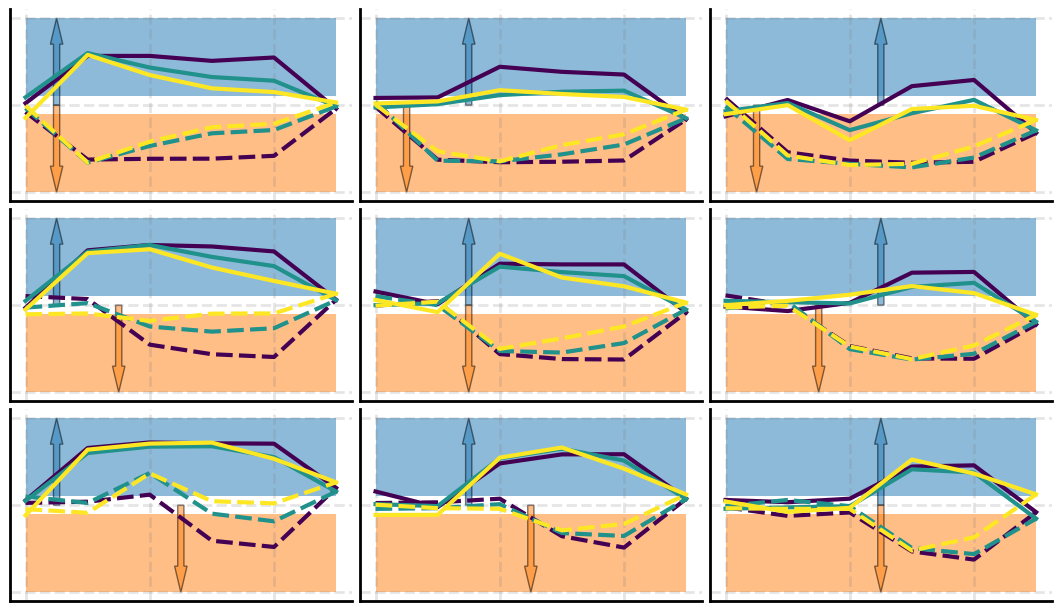

In [ ]:
fig, axs = plt.subplots(
    3, 3, figsize=(3 * 3.5, 3 * 2), constrained_layout=True, sharex=True, sharey=True
)
set_style()

for u, ax in zip(plot_data["t0_t1"].unique(), axs.T.flatten()):
    t0, t1 = u
    sns.lineplot(
        filter_data(
            plot_data, {"t0_t1": u, "n_conns": [n_conns[i] for i in [0, 1, 2]]}
        )[0],
        y="local_metric",
        x="step",
        ax=ax,
        style="ag",
        hue="n_conns",
        palette="viridis",
        hue_norm=LogNorm(),
    )
    # ax.vlines(x = [t0 - 0.5 ], ymin = -1, ymax = 1, color = 'blue', alpha = .2)
    # ax.vlines(x = [t1 - 0.5 ], ymin = -1, ymax = 1, color = 'red', alpha = .2)
    c1 = ax.fill_betweenx([0.1, 1], 0, nb_steps, alpha=0.5, label="M0")
    c2 = ax.fill_betweenx([-0.1, -1], 0, nb_steps, alpha=0.5, label="M1")

    ax.arrow(
        t0 - 0.5,
        0,
        0,
        1,
        alpha=0.5,
        width=0.1,
        head_width=0.2,
        facecolor=c1.get_facecolor()[0],
        edgecolor="black",
        length_includes_head=True,
        linewidth=1,
    )
    ax.arrow(
        t1 - 0.5,
        0,
        0,
        -1,
        alpha=0.5,
        width=0.1,
        head_width=0.2,
        facecolor=c2.get_facecolor()[0],
        edgecolor="black",
        length_includes_head=True,
        linewidth=1,
    )
    ax.legend()
    # ax.set_title(u)

    if t1 == 3:
        ax.set_xlabel("")
    else:
        ax.set_xlabel("")

    if t0 == 1:
        ax.set_ylabel("")
    else:
        ax.set_ylabel("")

    ax.legend().remove()

    ax.grid(True, alpha=0.2, linestyle="dashed", linewidth=2, color="grey")
    ax.set_yticklabels([])
    ax.set_xticklabels([])

    for tick in ax.xaxis.get_major_ticks():
        tick.tick1line.set_visible(False)
        tick.tick2line.set_visible(False)
        tick.label1.set_visible(False)
        tick.label2.set_visible(False)
    for tick in ax.yaxis.get_major_ticks():
        tick.tick1line.set_visible(False)
        tick.tick2line.set_visible(False)
        tick.label1.set_visible(False)
        tick.label2.set_visible(False)

# fig.savefig(f"../results/imgs/random_noisy_timings_new_3.svg")

In [ ]:
# plot_data.to_csv(f"../results/random_noisy_timings_data")